In [34]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"

#tokenize & pos tagging
tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

#ner
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)


[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]
(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


In [133]:
# NER using BiLSTM 

# retrieve training data

import urllib.request 

urllib.request.urlretrieve("https://raw.githubusercontent.com/soojeonge22/NER/main/data/train.txt", filename="train_ner.txt")

('train_ner.txt', <http.client.HTTPMessage at 0x7f91d590e090>)

In [58]:
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [85]:
#preprocessing

f = open('train_ner.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # split attributes by space
    splits[-1] = re.sub(r'\n', '', splits[-1]) # remove \n
    word = splits[0].lower() # lower the letter
    sentence.append([word, splits[-1]]) # store words and ner_tags

In [99]:
print("total samples: ", len(tagged_sentences)) # print the total number of the samples

total samples:  14040


In [100]:
print(tagged_sentences[0]) # print the first sample

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [101]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # call sentence samples one by one (from the total of 14,040 sentence samples)
    sentence, tag_info = zip(*tagged_sentence) # from each sample, store word info -> sentence, tagging info -> tag_info
    sentences.append(list(sentence)) # store word_info into sentences[]
    ner_tags.append(list(tag_info)) # store tag_info into ner_tags[]

In [102]:
print(sentences[0])   # word info
print(ner_tags[0])    # ner_tag info corresponding to word_info

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [103]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


the longest sample length : 113
the average sample length : 14.502635


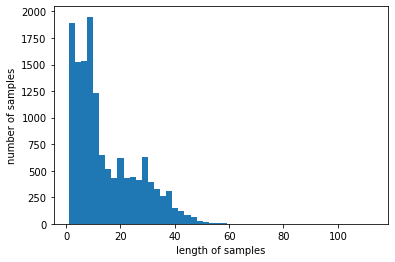

In [104]:
print('the longest sample length : %d' % max(len(l) for l in sentences))
print('the average sample length : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [105]:
# preparing for the training data

max_words = 4000

src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [106]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('vocab size : {}'.format(vocab_size))
print('tag size : {}'.format(tag_size))

vocab size : 4000
tag size : 10


In [107]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [108]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [109]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [113]:
decoded = []
for index in X_train[0] : # for the index in the first sample
    decoded.append(index_to_word[index]) # decode the index into the word

print('original sentence : {}'.format(sentences[0]))
print('after changing the lower-frequency word to OOV : {}'.format(decoded))

original sentence : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
after changing the lower-frequency word to OOV : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [114]:
max_len = 70

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [116]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [117]:
print('training sentence size : {}'.format(X_train.shape))
print('training label size : {}'.format(y_train.shape))
print('test sentence size : {}'.format(X_test.shape))
print('test label size : {}'.format(y_test.shape))

training sentence size : (11232, 70)
training label size : (11232, 70, 10)
test sentence size : (2808, 70)
test label size : (2808, 70, 10)


In [119]:
# ner taining starts

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [120]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [121]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [122]:
model.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 11s 49ms/step - loss: 0.1884 - accuracy: 0.8227 - val_loss: 0.1335 - val_accuracy: 0.8301
Epoch 2/8
88/88 [==============================] - 2s 21ms/step - loss: 0.1010 - accuracy: 0.8538 - val_loss: 0.0784 - val_accuracy: 0.8809
Epoch 3/8
88/88 [==============================] - 2s 28ms/step - loss: 0.0656 - accuracy: 0.9035 - val_loss: 0.0554 - val_accuracy: 0.9212
Epoch 4/8
88/88 [==============================] - 2s 23ms/step - loss: 0.0471 - accuracy: 0.9333 - val_loss: 0.0426 - val_accuracy: 0.9410
Epoch 5/8
88/88 [==============================] - 2s 21ms/step - loss: 0.0355 - accuracy: 0.9494 - val_loss: 0.0381 - val_accuracy: 0.9492
Epoch 6/8
88/88 [==============================] - 2s 21ms/step - loss: 0.0291 - accuracy: 0.9584 - val_loss: 0.0347 - val_accuracy: 0.9528
Epoch 7/8
88/88 [==============================] - 2s 21ms/step - loss: 0.0249 - accuracy: 0.9640 - val_loss: 0.0336 - val_accuracy: 0.9540
Epoch 8/8
88/88 [==

In [123]:
print("\n accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 1s 7ms/step - loss: 0.0329 - accuracy: 0.9565

 accuracy: 0.9565


In [129]:
i=10 # index of test sample to check
y_predicted = model.predict(np.array([X_test[i]])) # retrun y for the input test sample
y_predicted = np.argmax(y_predicted, axis=-1) # convert the prob vector into the integer encoding
true = np.argmax(y_test[i], -1) # convert one-hot vector into the integer encoding

print("{:17}|{:8}|{}".format("word", "actual", "predicted"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # except for PAD
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

word             |actual  |predicted
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O 